# Directory Deep Content Cluster Visualization

## Overview

- Deep dive the provided directory, a Zettelkasten note-taking repo, to visualize content clusters.



--- Top Bi-gram Identifiers per Cluster ---
Cluster 0: rescue squad, social media, don want, small farms, help navigate, public safety, sense community, high quality
Cluster 1: book author, author book, peak performance, information marketer, sales marketing, wikipedia wiki, en wikipedia, bob bly
Cluster 2: local business, martinsville va, g_face q_auto, future work, future generations, function skills, fulfilling life, fulfilling career
Cluster 3: artificial intelligence, ai systems, training data, language model, use ai, hiring managers, ai models, knowledge worker
Cluster 4: point notes, notes reference, bullet point, accessed 2023, justin hitt, 30 years, desired outcome, martinsville va
Cluster 5: risk management, management risk, business development, management business, justin hitt, operational risk, management professionals, management professional
Cluster 6: better sleep, sleep hygiene, natural sleep, sleep better, sleep wake, sleep deprivation, poor sleep, sleep sleep
Cluste

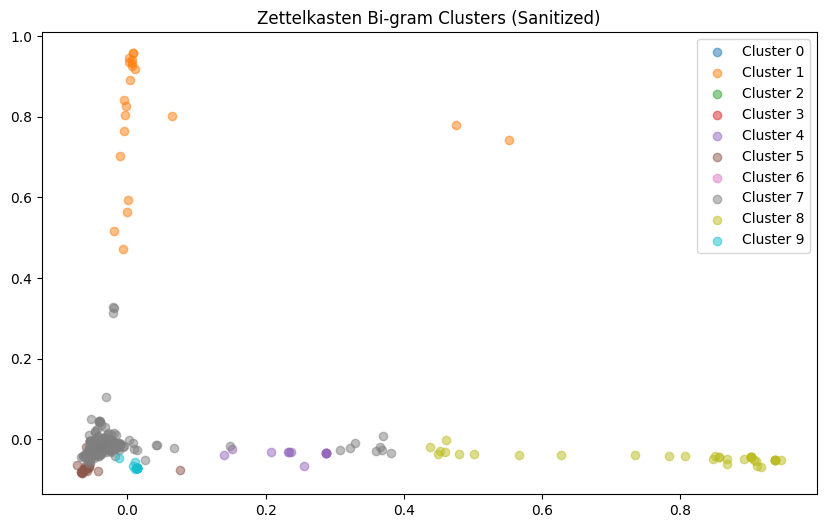

In [3]:
import os
import re
import sys
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# --- Configuration ---
# ZETTEL_ROOT = "/home/hittjw/Documents/GitHub/obsidian/Zettelkasten" # Ubuntu
ZETTEL_ROOT = "/workspace/obsidian/Zettelkasten" # K8S
N_CLUSTERS = 10
TAG_WEIGHT = 5 

def clean_headers(text):
    """Removes Markdown headers with 2 words or fewer."""
    lines = text.split('\n')
    filtered_lines = []
    for line in lines:
        if line.startswith('#'):
            header_content = re.sub(r'^#+\s*', '', line).strip()
            if len(header_content.split()) > 2:
                filtered_lines.append(line)
        else:
            filtered_lines.append(line)
    return '\n'.join(filtered_lines)

def split_camel_case(text):
    """Splits #CamelCase into 'Camel Case'."""
    return re.sub(r'([a-z])([A-Z])', r'\1 \2', text)

def is_date_pattern(text):
    """Check if text is a date pattern like YYYY-MM-DD or YYYYMMDD."""
    text_str = str(text).strip()
    # Match YYYY-MM-DD, YYYY-MM, or YYYYMMDD patterns
    return bool(re.match(r'^\d{4}(-\d{2}(-\d{2})?)?$|^\d{8}', text_str))

def extract_note_data(filepath):
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            content = f.read()
    except (OSError, IOError) as e:
        sys.stderr.write(f"read_error: {filepath} - {e}\n")
        return None, None

    # 1. YAML Tags with NoneType protection - Ignore tags with date patterns
    yaml_tags = []
    yaml_match = re.search(r'^---\s*\n(.*?)\n---\s*\n', content, re.DOTALL)
    if yaml_match:
        try:
            meta = yaml.safe_load(yaml_match.group(1))
            if meta and 'tags' in meta:
                raw_tags = meta['tags']
                if isinstance(raw_tags, list):
                    # Filter out None values and date patterns
                    yaml_tags = [str(t) for t in raw_tags if t is not None and not is_date_pattern(t)]
                elif raw_tags is not None:
                    if not is_date_pattern(raw_tags):
                        yaml_tags = [str(raw_tags)]
        except yaml.YAMLError:
            pass

    # 2. Hashtags - Extracted and Split (Ignore hashtags with date patterns)
    hashtag_raw = re.findall(r'#([A-Z][a-z]+(?:[A-Z][a-z]+)+)', content)
    hashtag_raw = [ht for ht in hashtag_raw if not is_date_pattern(ht)]
    hashtag_split = [split_camel_case(ht) for ht in hashtag_raw]
    
    # 3. Clean Body (Strip front matter, then filter headers, then remove date patterns)
    body = re.sub(r'^---\s*\n(.*?)\n---\s*\n', '', content, flags=re.DOTALL)
    body = clean_headers(body)
    # Remove date patterns before tokenizing
    body = re.sub(r'\d{4}-\d{2}-\d{2}|\d{4}-\d{2}|\d{8}', '', body)
    
    # Safely join strings
    meta_str = (" ".join(yaml_tags) + " " + " ".join(hashtag_split) + " ") * TAG_WEIGHT
    
    feature_text = meta_str + body
    return feature_text.strip(), filepath.name

# --- Data Loading ---
data = []
files = list(Path(ZETTEL_ROOT).rglob('*.[mM][dD]'))
for path in files:
    text, name = extract_note_data(path)
    if text:
        data.append({'name': name, 'text': text})

if not data:
    sys.stderr.write("extraction_failed: No content found.\n")
    sys.exit(1)

df = pd.DataFrame(data)

# --- Stop Word Refinement ---
custom_stops = {'https', 'http', 'com', 'www', 'org', 'net', 'html', 'eof'}
all_stop_words = list(ENGLISH_STOP_WORDS.union(custom_stops))

# --- Vectorization ---
vectorizer = TfidfVectorizer(
    stop_words=all_stop_words,
    ngram_range=(2, 2), 
    max_features=2000
)

X = vectorizer.fit_transform(df['text'])

# --- Clustering ---
model = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
df['cluster'] = model.fit_predict(X)

# --- PCA ---
pca = PCA(n_components=2)
coords = pca.fit_transform(X.toarray())
df['x'], df['y'] = coords[:, 0], coords[:, 1]

# --- Identification ---
print("\n--- Top Bi-gram Identifiers per Cluster ---")
terms = vectorizer.get_feature_names_out()
centroids = model.cluster_centers_.argsort()[:, ::-1]

for i in range(N_CLUSTERS):
    top_terms = [terms[ind] for ind in centroids[i, :8]]
    print(f"Cluster {i}: {', '.join(top_terms)}")


# --- Visualization ---
plt.figure(figsize=(10, 6))
for i in range(N_CLUSTERS):
    slice_df = df[df['cluster'] == i]
    plt.scatter(slice_df['x'], slice_df['y'], label=f"Cluster {i}", alpha=0.5)

plt.title("Zettelkasten Bi-gram Clusters (Sanitized)")
plt.legend()
plt.show()
